In [1]:
import requests
import re
import pandas as pd
import random
from string import ascii_lowercase
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

In [2]:
# Download NLTK stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to clean text: remove punctuation, stop words, and non-textual elements
def clean_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Split into words
    words = text.split()
    # Remove stop words and non-textual elements
    cleaned_words = [word for word in words if word.lower() not in stop_words]
    # strip underscores
    cleaned_words = [word.strip('_') for word in cleaned_words]
    # remove numbers
    cleaned_words = [word for word in cleaned_words if not word.isnumeric()]
    return ' '.join(cleaned_words)

def find_start_end(text):
    # Find the start and end of the main text
    start_pattern = r"\*\*\* START OF THIS PROJECT GUTENBERG EBOOK .+ \*\*\*"
    end_pattern = r"\*\*\* END OF THIS PROJECT GUTENBERG EBOOK .+ \*\*\*"

    start_match = re.search(start_pattern, text)
    end_match = re.search(end_pattern, text)

    start_idx = start_match.end() if start_match else 0
    end_idx = end_match.start() if end_match else len(text)

    return text[start_idx:end_idx]

def process_book(url, label):
    # Download the book text from the URL
    response = requests.get(url)
    response.encoding = 'utf-8'
    text = response.text

    # Extract the main text between start and end markers
    main_text = find_start_end(text)

    # Clean the main text
    cleaned_text = clean_text(main_text)

    # Extract words from the cleaned text
    words = cleaned_text.split()

    # Split words into partitions of 100 and take 200 random partitions
    partitions = [words[i:i + 100] for i in range(0, len(words), 100)]
    random_partitions = random.sample(partitions, min(200, len(partitions)))

    return [(label, ' '.join(partition)) for partition in random_partitions]

# Updated list of Gutenberg book URLs (Same as before, no change needed here)
book_urls = [
    'https://www.gutenberg.org/files/1342/1342-0.txt',  # Pride and Prejudice by Jane Austen
    'https://www.gutenberg.org/files/768/768-0.txt',    # Wuthering Heights by Emily Brontë
    'https://www.gutenberg.org/files/1260/1260-0.txt',  # Jane Eyre by Charlotte Brontë
    'https://www.gutenberg.org/files/1400/1400-0.txt',  # Great Expectations by Charles Dickens
    'https://www.gutenberg.org/files/145/145-0.txt',    # Middlemarch by George Eliot
    'https://www.gutenberg.org/files/541/541.txt'       # The Age of Innocence by Edith Wharton
]

book_authors = ["Jane Austen", "Emily Bronte", "Charlotte Bronte", "Charles Dickens",  "George Eliot", "Edith Wharton"]


# Process all books
all_partitions = []

for url, label in zip(book_urls, book_authors):
    book_partitions = process_book(url, label)
    all_partitions.extend(book_partitions)

# Convert to DataFrame
partition_df = pd.DataFrame(all_partitions, columns=['Label', 'Words']).sample(frac=1)

# Serialize DataFrame to CSV
partition_df.to_csv('book_partitions_cleaned.csv', index=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

In [4]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from sklearn.multiclass import OneVsRestClassifier

In [5]:
model_objs = [
    OneVsRestClassifier(SVC(kernel="rbf")),
    RandomForestClassifier(),
    OneVsRestClassifier(GaussianNB()),
    KNeighborsClassifier(),
    OneVsRestClassifier(SGDClassifier()),
    DecisionTreeClassifier(),
    OneVsRestClassifier(AdaBoostClassifier()),
    OneVsRestClassifier(XGBClassifier(random_state=69))
    ]


model_names = [
    "Gaussian SVC",
    "RandomForestClassifier",
    "Naive Bayes",
    "KNeighborsClassifier",
    "SGDClassifier",
    "DecisionTreeClassifier",
    "AdaBoostClassifier",
    "XGBClassifier",
]

In [6]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
import warnings
warnings.filterwarnings('ignore')

# Split data into train, validation, and test sets
train_val_df, test_df = train_test_split(partition_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

# Initialize vectorizers
tfidf_vectorizer = TfidfVectorizer()
bow_vectorizer = CountVectorizer()

# KFold setup
kf = KFold(n_splits=10, shuffle=True, random_state=69)
onehot_encoder = OneHotEncoder(sparse=False)

def train_and_evaluate(vectorizer, model_objs, model_names, train_df, val_df):
    results = []

    X_train_vect = vectorizer.fit_transform(train_df['Words'])
    X_val_vect = vectorizer.transform(val_df['Words'])

    X_train_vect_df = pd.DataFrame(X_train_vect.toarray(), columns=vectorizer.get_feature_names_out())
    X_val_vect_df = pd.DataFrame(X_val_vect.toarray(), columns=vectorizer.get_feature_names_out())

    y_train_onehot = onehot_encoder.fit_transform(train_df[['Label']])
    y_val_onehot = onehot_encoder.transform(val_df[['Label']])

    y_train_df = pd.DataFrame(y_train_onehot, columns=onehot_encoder.get_feature_names_out(['Label']))
    y_val_df = pd.DataFrame(y_val_onehot, columns=onehot_encoder.get_feature_names_out(['Label']))

    for model, model_name in zip(model_objs, model_names):
        model.fit(X_train_vect_df, y_train_df)
        y_val_pred = model.predict(X_val_vect_df)

        acc = accuracy_score(y_val_df, y_val_pred)
        precision = precision_score(y_val_df, y_val_pred, average='macro')
        recall = recall_score(y_val_df, y_val_pred, average='macro')
        f1 = f1_score(y_val_df, y_val_pred, average='macro')
        roc_auc = roc_auc_score(y_val_df, y_val_pred, average='macro')

        results.append({
            'Model': model_name,
            'Vectorization': vectorizer.__class__.__name__,
            'Accuracy': acc,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC AUC': roc_auc
        })

    return pd.DataFrame(results)

# Collect results
tfidf_results = train_and_evaluate(tfidf_vectorizer, model_objs, model_names, train_df, val_df)
bow_results = train_and_evaluate(bow_vectorizer, model_objs, model_names, train_df, val_df)

# Combine results
all_results = pd.concat([tfidf_results, bow_results], ignore_index=True)

# Save to CSV
all_results.to_csv('model_evaluation_results.csv', index=False)


In [7]:
def select_best_model(results_df):
    # Selecting the model with the highest F1-Score
    best_model = results_df.loc[results_df['F1-Score'].idxmax()]
    return best_model

# Choose the best model
best_model_info = select_best_model(all_results)
print("Best Model based on F1-Score:")
print(best_model_info)

Best Model based on F1-Score:
Model            KNeighborsClassifier
Vectorization         TfidfVectorizer
Accuracy                     0.820833
Precision                    0.965322
Recall                       0.836079
F1-Score                     0.884914
ROC AUC                      0.914729
Name: 3, dtype: object


In [ ]:
# Vectorize the test data
X_test_vect = vectorizer.transform(test_df['Words'])  # Use the same vectorizer as the champion model (TF-IDF or BoW)
X_test_vect_df = pd.DataFrame(X_test_vect.toarray(), columns=vectorizer.get_feature_names_out())

# One-hot encoding for test labels
y_test_onehot = onehot_encoder.transform(test_df[['Label']])
y_test_df = pd.DataFrame(y_test_onehot, columns=onehot_encoder.get_feature_names_out(['Label']))

# Make predictions
y_test_pred = best_model.predict(X_test_vect_df)


In [ ]:
print(y_pred)

[[0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 1 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 1 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 1 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 1 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 1 0 0 0 0]
 [0 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 1 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 0 1]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 0 1]]


In [ ]:
y_test_df

,Label_Charles Dickens,Label_Charlotte Bronte,Label_Edith Wharton,Label_Emily Bronte,Label_George Eliot,Label_Jane Austen
0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0
6,0.0,0.0,0.0,0.0,1.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,1.0
9,0.0,0.0,0.0,0.0,0.0,1.0


# BERT

In [ ]:
!pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 50.4 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[-0.25969836 -0.52364445  0.9036142  -0.55134004 -0.88770914  0.9886292
 -0.30357572 -0.00745822 -0.9583914   0.06638025  0.23976119  0.06133483]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.1338202   0.03000332  0.17117347 ... -0.47139746 -0.92813057
   0.51842195]
 [-0.05726065  1.0102304  -0.164846   ... -0.77384204 -0.5603515
   0.07679403]
 [-1.2910262   0.0331322   0.7465316  ... -0.45870095  0.32357264
   0.24169521]
 ...
 [ 0.01642712  0.0605648   0.43864334 ...  0.24693727 -0.2777899
   0.3536233 ]
 [-0.3973329   0.0986197   0.16961995 ...  0.16997036 -0.6732824
   0.42493147]
 [ 0.16625747 -0.19789703 -0.4526961  ...  0.31699604 -0.6168943
   0.11923101]]


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dense(128, activation='relu', name='hidden_1')(net)
  net = tf.keras.layers.Dropout(0.3)(net)
  net = tf.keras.layers.Dense(6, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(bert_raw_result)

tf.Tensor([[0.11506798 0.09176406 0.11182143 0.13499951 0.20483865 0.34150836]], shape=(1, 6), dtype=float32)


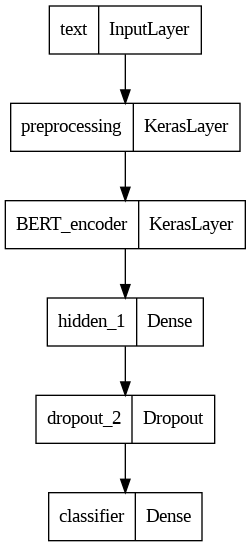

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.metrics.CategoricalAccuracy()

In [ ]:
X = partition_df.drop(['Label'], axis=1)
y = partition_df['Label']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import warnings
import numpy as np
warnings.filterwarnings('ignore')

onehot_encoder = OneHotEncoder(sparse=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_onehot = onehot_encoder.fit_transform(np.array(y_train).reshape(-1,1))
y_test_onehot = onehot_encoder.transform(np.array(y_test).reshape(-1,1))

y_train_df = pd.DataFrame(y_train_onehot, columns=onehot_encoder.get_feature_names_out(['Label']))
y_test_df = pd.DataFrame(y_test_onehot, columns=onehot_encoder.get_feature_names_out(['Label']))

In [ ]:
y_train_df

,Label_Charles Dickens,Label_Charlotte Bronte,Label_Edith Wharton,Label_Emily Bronte,Label_George Eliot,Label_Jane Austen
0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
955,0.0,0.0,1.0,0.0,0.0,0.0
956,0.0,0.0,1.0,0.0,0.0,0.0
957,0.0,0.0,1.0,0.0,0.0,0.0
958,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
epochs = 10
optimizer = tf.keras.optimizers.Adam(0.0001)

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
classifier_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                           
                              128)}                                                               
                                                                                            

In [ ]:
history = classifier_model.fit(X_train,y_train_df, batch_size=128, epochs=epochs, validation_data=(X_test, y_test_df))

Epoch 1/10
8/8 [==============================] - 19s 1s/step - loss: 0.0058 - categorical_accuracy: 0.9875 - val_loss: 0.4048 - val_categorical_accuracy: 0.9333
Epoch 2/10
8/8 [==============================] - 8s 951ms/step - loss: 0.0057 - categorical_accuracy: 0.9990 - val_loss: 0.3832 - val_categorical_accuracy: 0.9417
Epoch 3/10
8/8 [==============================] - 8s 1s/step - loss: 0.0054 - categorical_accuracy: 0.9990 - val_loss: 0.3831 - val_categorical_accuracy: 0.9333
Epoch 4/10
8/8 [==============================] - 9s 1s/step - loss: 0.0076 - categorical_accuracy: 0.9979 - val_loss: 0.4578 - val_categorical_accuracy: 0.9250
Epoch 5/10
8/8 [==============================] - 9s 1s/step - loss: 0.0045 - categorical_accuracy: 0.9969 - val_loss: 0.3784 - val_categorical_accuracy: 0.9417
Epoch 6/10
8/8 [==============================] - 8s 964ms/step - loss: 0.0029 - categorical_accuracy: 0.9990 - val_loss: 0.3567 - val_categorical_accuracy: 0.9500
Epoch 7/10
8/8 [===========

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
y_pred = to_categorical(np.argmax(classifier_model.predict(X_test), axis=-1))

8/8 [==============================] - 1s 156ms/step


In [ ]:
y_pred

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
acc = accuracy_score(y_pred, y_test_df)
precision = precision_score(y_pred, y_test_onehot, average='macro')
recall = recall_score(y_pred, y_test_onehot, average='macro')
f1 = f1_score(y_pred, y_test_onehot, average='macro')
roc_auc = roc_auc_score(y_test_onehot, y_pred, average='macro')

In [ ]:
print("Average Accuracy: {}".format(acc))
print("Average Precision: {}".format(precision))
print("Average Recall: {}".format(recall))
print("Average F1: {}".format(f1))
print("Average ROC AUC: {}".format(roc_auc))

Average Accuracy: 0.9458333333333333
Average Precision: 0.9465236274446801
Average Recall: 0.9463038848866577
Average F1: 0.9460698238758353
Average ROC AUC: 0.9678226909254906


In [ ]:
classifier_model.save('BERT_classifier.h5')